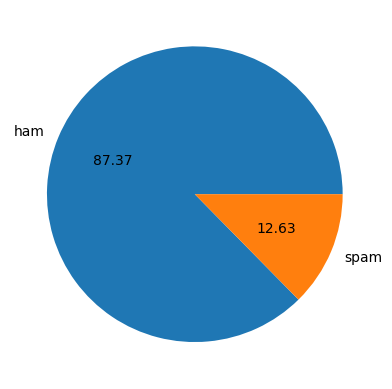

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


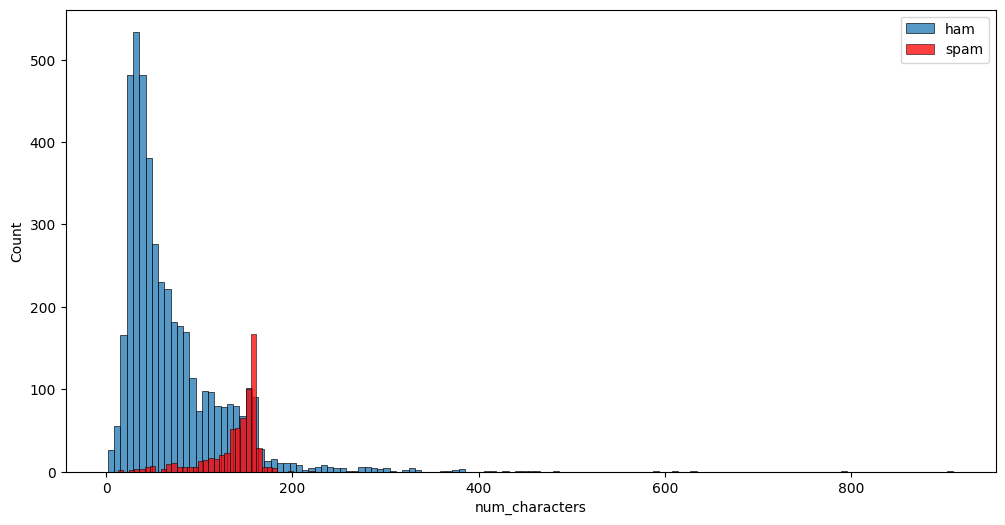

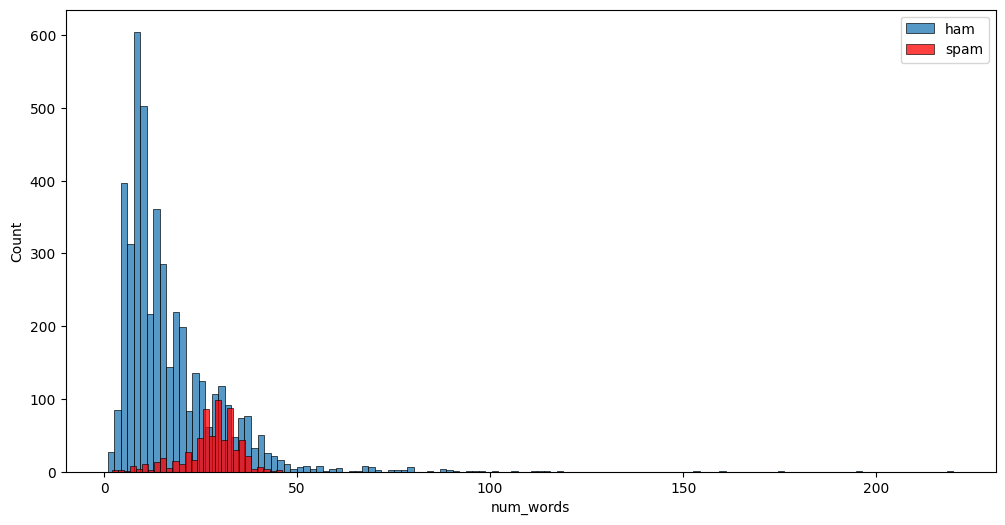

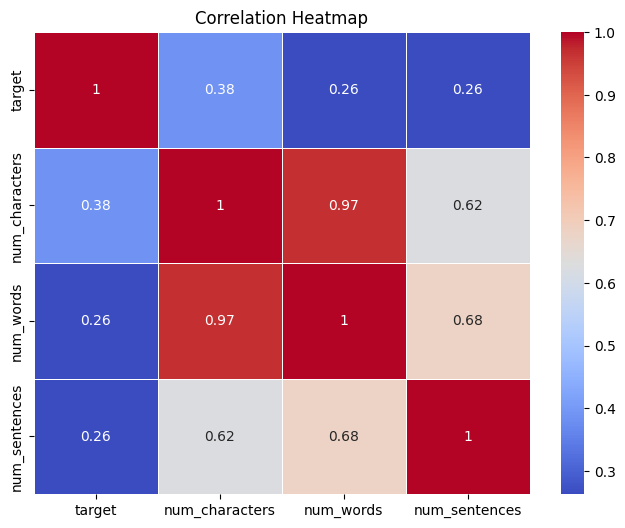

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


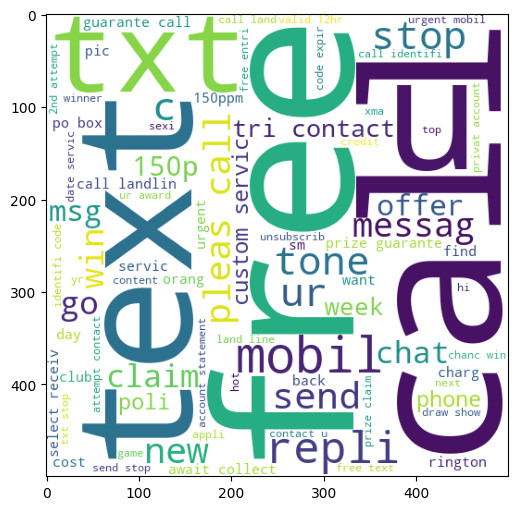

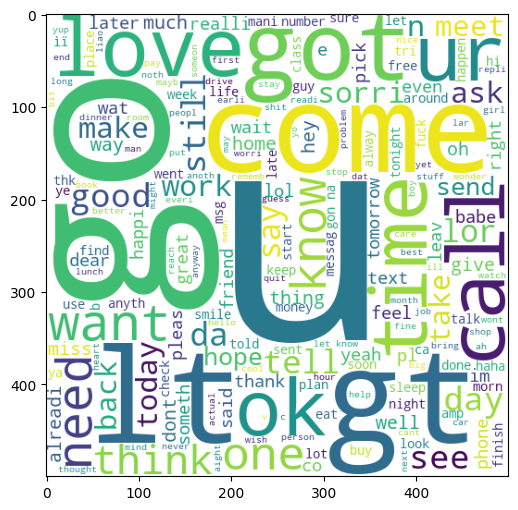

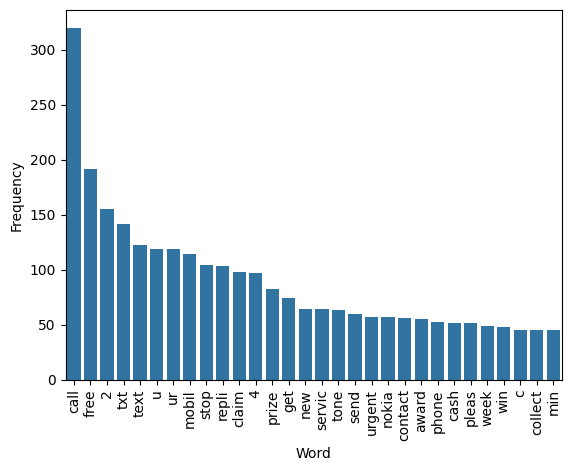

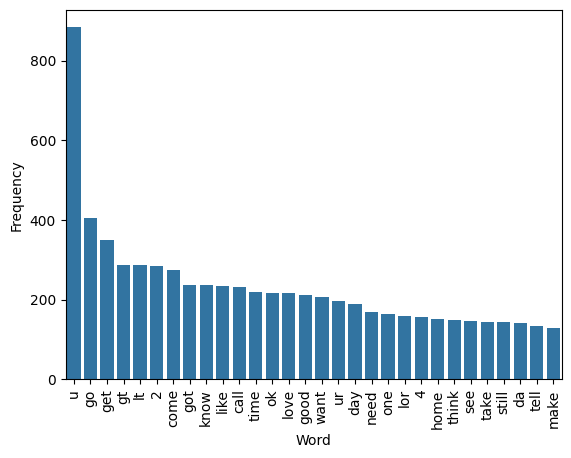

GaussianNB: (0.8733075435203095, np.float64(0.5159817351598174))
MultinomialNB: (0.9709864603481625, np.float64(1.0))
BernoulliNB: (0.9835589941972921, np.float64(0.991869918699187))
SVC: Accuracy = 0.9758220502901354, Precision = 0.9747899159663865
KN: Accuracy = 0.9052224371373307, Precision = 1.0
NB: Accuracy = 0.9709864603481625, Precision = 1.0
DT: Accuracy = 0.9294003868471954, Precision = 0.8282828282828283
LR: Accuracy = 0.9564796905222437, Precision = 0.9696969696969697
RF: Accuracy = 0.97678916827853, Precision = 0.975


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost: Accuracy = 0.9690522243713733, Precision = 0.9732142857142857
BgC: Accuracy = 0.9593810444874274, Precision = 0.8692307692307693
ETC: Accuracy = 0.9777562862669246, Precision = 0.967479674796748
GBDT: Accuracy = 0.9506769825918762, Precision = 0.9306930693069307
xgb: Accuracy = 0.9680851063829787, Precision = 0.9338842975206612


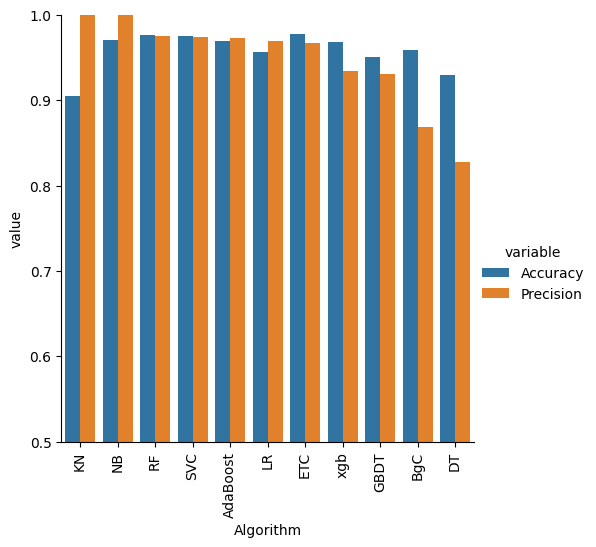

Voting Classifier: Accuracy = 0.9796905222437138 Precision = 0.9834710743801653
Stacking Classifier: Accuracy = 0.9777562862669246 Precision = 0.9323308270676691


In [2]:

import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score
from collections import Counter
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle
from xgboost import XGBClassifier
# Load the dataset
df = pd.read_csv(r"C:\Users\HP\Desktop\span_detector\spam.csv", encoding='latin1')

# Data cleaning
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

# Encode the target variable
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

# Remove duplicates
df = df.drop_duplicates(keep='first')

# Visualize the target distribution
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

# Adding features for analysis
nltk.download('punkt')
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Data visualization
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 0]['num_characters'], label='ham')
sns.histplot(df[df['target'] == 1]['num_characters'], color='red', label='spam')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 0]['num_words'], label='ham')
sns.histplot(df[df['target'] == 1]['num_words'], color='red', label='spam')
plt.legend()
plt.show()

# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Text preprocessing
nltk.download('stopwords')
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [i for i in text if i.isalnum()]
    text = [i for i in text if i not in stopwords.words('english') and i not in string.punctuation]
    text = [ps.stem(i) for i in text]
    return " ".join(text)

df['transformed_text'] = df['text'].apply(transform_text)

# Word cloud visualization
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)
plt.show()

ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(ham_wc)
plt.show()

# Most common words
spam_corpus = [word for msg in df[df['target'] == 1]['transformed_text'].tolist() for word in msg.split()]
ham_corpus = [word for msg in df[df['target'] == 0]['transformed_text'].tolist() for word in msg.split()]

# Visualizing most common spam words
common_spam_words = Counter(spam_corpus).most_common(30)
common_spam_words_df = pd.DataFrame(common_spam_words, columns=['Word', 'Frequency'])
sns.barplot(x='Word', y='Frequency', data=common_spam_words_df)
plt.xticks(rotation='vertical')
plt.show()

# Visualizing most common ham words
common_ham_words = Counter(ham_corpus).most_common(30)
common_ham_words_df = pd.DataFrame(common_ham_words, columns=['Word', 'Frequency'])
sns.barplot(x='Word', y='Frequency', data=common_ham_words_df)
plt.xticks(rotation='vertical')
plt.show()

# Model building
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Naive Bayes classifiers
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

# Training and evaluating classifiers
def evaluate_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred), precision_score(y_test, y_pred)

print("GaussianNB:", evaluate_model(gnb, X_train, y_train, X_test, y_test))
print("MultinomialNB:", evaluate_model(mnb, X_train, y_train, X_test, y_test))
print("BernoulliNB:", evaluate_model(bnb, X_train, y_train, X_test, y_test))

# Other classifiers
clfs = {
    'SVC': SVC(kernel='sigmoid', gamma=1.0),
    'KN': KNeighborsClassifier(),
    'NB': MultinomialNB(),
    'DT': DecisionTreeClassifier(max_depth=5),
    'LR': LogisticRegression(solver='liblinear', penalty='l1'),
    'RF': RandomForestClassifier(n_estimators=50, random_state=2),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=2),
    'BgC': BaggingClassifier(n_estimators=50, random_state=2),
    'ETC': ExtraTreesClassifier(n_estimators=50, random_state=2),
    'GBDT': GradientBoostingClassifier(n_estimators=50, random_state=2),
    'xgb': XGBClassifier(n_estimators=50, random_state=2)
}

# Evaluate and compare classifiers
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    accuracy, precision = evaluate_model(clf, X_train, y_train, X_test, y_test)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    print(f"{name}: Accuracy = {accuracy}, Precision = {precision}")

# Visualization of performance
performance_df = pd.DataFrame({'Algorithm': clfs.keys(), 'Accuracy': accuracy_scores, 'Precision': precision_scores}).sort_values('Precision', ascending=False)
performance_df_melted = pd.melt(performance_df, id_vars='Algorithm')
sns.catplot(x='Algorithm', y='value', hue='variable', data=performance_df_melted, kind='bar', height=5)
plt.ylim(0.5, 1.0)
plt.xticks(rotation='vertical')
plt.show()

# Voting classifier
voting = VotingClassifier(estimators=[('svm', SVC(kernel='sigmoid', gamma=1.0, probability=True)), ('nb', MultinomialNB()), ('et', ExtraTreesClassifier(n_estimators=50, random_state=2))], voting='soft')
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print("Voting Classifier: Accuracy =", accuracy_score(y_test, y_pred), "Precision =", precision_score(y_test, y_pred))

# Stacking classifier
stacking = StackingClassifier(estimators=[('svm', SVC(kernel='sigmoid', gamma=1.0, probability=True)), ('nb', MultinomialNB()), ('et', ExtraTreesClassifier(n_estimators=50, random_state=2))], final_estimator=RandomForestClassifier())
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)
print("Stacking Classifier: Accuracy =", accuracy_score(y_test, y_pred), "Precision =", precision_score(y_test, y_pred))

# Saving the models
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))
